### 사용자 행동 인식 예측 분류

- 결정 트리를 이용하여 UCI Machine Learning Repository에서 제공하는 사용자 행동 인식 데이터셋에 대한 예측 분류를 해보자

- 해당 데이터는 30명에게 스마트폰 센서를 장착한 뒤 사람의 동작과 관련된 여러가지 피처를 수집한 데이터이다

- https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

- 피처는 모두 561개, 공백으로 분리되어 있음

In [2]:
from google.colab import files

uploaded = files.upload()

Saving features.txt to features.txt


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

#features.txt파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드
feature_name_df = pd.read_csv('features.txt', sep='\s+', header=None, names=['column_index', 'column_name'] )

#피처명 index를 제거하고, 피터명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:',feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


- 인체의 움직임과 관련된 속성의 평균/표준편차가 x, y, z축 값으로 되어있음을 유추할 수 있다

- feature.txt 파일은 중복된 피처명을 가지고 있음, 이 상태로 DataFrame으로 만들면 오류 발생

- 중복된 피처명에는 원본 피처명에 _1, _2를 추가로 붙여서 해결하기

##### 중복된 피처명이 얼마나 있는지 먼저 확인해보자

In [4]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


- 총 42개의 피처명이 중복되어있음


##### get_new_feature_name_df() 함수를 생성하여 새로운 피처명을 가지는 DataFrame을 반환해보자

In [5]:
def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
  feature_dup_df = feature_dup_df.reset_index()
  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis=1)
  new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
  return new_feature_name_df

##### train 디렉터리에 있는 학습용 데이터셋과 test 디렉터리에 있는 테스트용 데이터셋을 각각 DataFrame으로 로드하자

- 레이블의 칼럼은 'action'으로 명명

- DataFrame을 생성하는 로직을 get_human_dataset()이라는 함수로 생성

In [10]:
import pandas as pd

def get_human_dataset():

  #각 데이터 파일은 공백으로 분리되어 있어서 공백 문자를 sep으로 할당
  feature_name_df = pd.read_csv('features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])

  #중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
  new_feature_name_df = get_new_feature_name_df(feature_name_df)

  #DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트로 다시 변환
  feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

  #학습 피처 데이터셋과 테스트 피처 데이터를 DataFrame으로 로딩, 칼러명은 feature_name을 적용
  X_train = pd.read_csv('/X_train.txt', sep='\s+', names=feature_name)
  X_test = pd.read_csv('/X_test.txt', sep='\s+', names=feature_name)


  #레이블 데이터도 마찬가지
  y_train = pd.read_csv('/y_train.txt', sep='\s+', header=None, names=['action'])
  y_test = pd.read_csv('/y_test.txt', sep='\s+', header=None, names=['action'])

  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [12]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


- 레이블값은 1, 2, 3, 4, 5, 6으로 6개, 분포는 특정값으로 왜곡되지 않고 비교적 고름

##### DecisionTreeClassifier를 이용해 동작 예측 분류를 수행하자

- 하이퍼 파라미터는 모두 디폴트로 설정

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#예제 반복 시마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

#하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터" \n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터" 
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


##### 1. 결정트리의 트리 깊이가 예측 정확도에 주는 영향 살펴보기

- GridSearchCV를 이용해 min_samples_split=16으로 고정하고 max_depth 값을 6, 8, 10, 12, 16, 20, 24로 변화시키면서 성능 확인해보자, 교차 검증은 5개 세트

In [14]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth': [6, 8, 10, 12, 16, 20, 24], 'min_samples_split':[16]}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


- max_depth=8일 때, 5개의 폴드세트의 최고 평균 정확도 결과가 약 85.49%로 도출

#####  2. 5개의 CV 세트에서 max_depth값에 따라 어떻게 예측 성능이 변했는지 GridSearchCV 객체의 cv_results_ 속성을 통해 살펴보자

- cv_results_ 속성은 CV세트에 하이퍼 파라미터를 순차적으로 입력했을 때의 성능 수치를 가지고 있음



In [15]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

#max_depth값과 그때의 테스트 세트, 학습데이터셋의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.847662
1,8,0.854879
2,10,0.852705
3,12,0.845768
4,16,0.847127
5,20,0.848624
6,24,0.848624


- mean_test_score은 5개의 cv세트에서 검증용 데이터셋의 정확도 평균 수치

##### 3. 별도의 테스트 데이터셋에서 결정 트리의 정확도를 측정해보자, min_samples_split=16으로 고정하고 max_depth값을 변화시키면서 

In [17]:
max_depths = [6, 8, 10, 12, 14, 16, 20, 24]
for depth in max_depths:
  dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=156)
  dt_clf.fit(X_train, y_train)
  pred = dt_clf.predict(X_test)
  accuracy = accuracy_score(y_test, pred)
  print('max_depth = {0} 정확도: {1:.4f}'.format(depth, accuracy))

max_depth = 6 정확도: 0.8551
max_depth = 8 정확도: 0.8717
max_depth = 10 정확도: 0.8599
max_depth = 12 정확도: 0.8571
max_depth = 14 정확도: 0.8554
max_depth = 16 정확도: 0.8599
max_depth = 20 정확도: 0.8565
max_depth = 24 정확도: 0.8565


- max_depth=8일 경우 약 87.17%로 가장 높은 정확도 나타냄, 8을 넘어갈수록 정확도 계속 감소함

##### 4. max_depth와 min_samples_split 같이 변경하면서 정확도 성능 튜닝하기

In [18]:
params = {'max_depth':[8, 12, 16, 20], 'min_samples_split':[16, 24]}

grid_cv = GridSearchCV(dt_clf, param_grid=params, cv=5, scoring='accuracy', verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


- max_depth=8, min_samples_split=16일 때 가장 최고의 정확도로 약 85.49%를 나타냄

##### 5.별도로 분리된 테스트 데이터셋에 해당 하이퍼 파라미터를 적용하자

- grid_cv의 속성은 best_estimator_는 최적 하이퍼 파라미터인 max_depth=8, min_samples_split=16으로 학습이 완료된 Estimatior

In [19]:
best_dt_clf = grid_cv.best_estimator_
pred1 = best_dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

결정 트리 예측 정확도: 0.8717


##### 6. 마지막으로 결정 트리에서 각 피처의 중요도를 feature_importances_ 속성을 통해 알아보자

- barplot을 통해 중요도가 높은 top20 나타내기

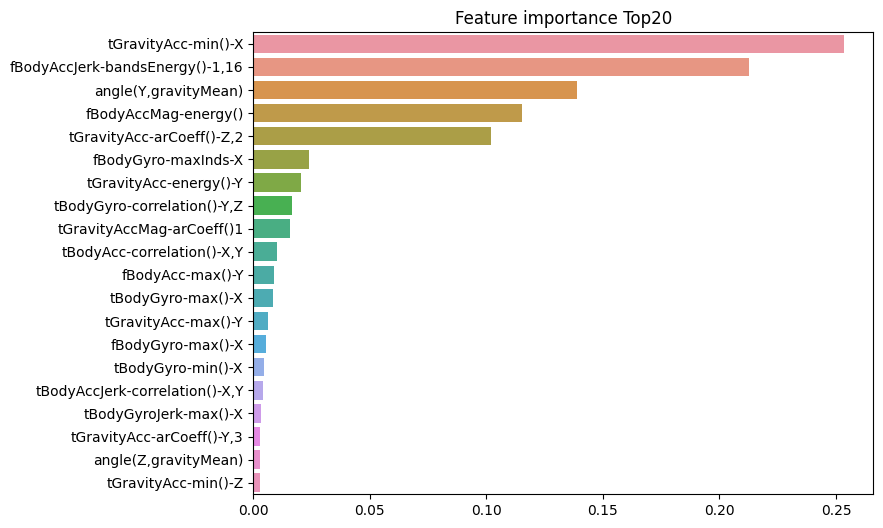

In [20]:
import seaborn as sns

ftr_importances_values = best_dt_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)

ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importance Top20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()                                 

- 막대그래프에서 확인할 수 있듯이 가장 높은 중요도를 가진 Top5 피처들이 매우 중요하게 규칙 생성에 영향을 미침